In general we have this process:

0. Download data from MathSciNet website and save data to Json format files using the following steps:
   a. Save netid and user password to credential.py file, inspect id's for buttoms in the log-in pages, use the .click() function and .sleep() from webdriver package to fulfill the auto sign-in.
   b. Inspect the id of the search bar and search publications of math professors, using the .click() and sleep() functions again.
   c. Click on each of the publications and download the information of references, Msc Code and Journal for corresponding paper.
   d. Save information to each of the professors as Json file [professor]_papers.json (e.g TolmanSusan_papers.json) in format: 
     {PaperA: {Title, PaperID, Author, Journal_Name, Publication_Year, References, Codes}
      PaperB: {Title, PaperID, Author, Journal_Name, Publication_Year, References, Codes}
      ...
     }
     (PS. Codes is the Msc category code)

1. Extract the raw data on MSC codes, References, and Journals for each professor in the department:
   a. Extract "Journal_Name" index for Journals, "References" index for References, and "Codes" for Msc Codes from [professor]_papers.json files.

2. Compare the data between each professor, determine how to quantify their similarity, and then store the data into a similarity matrix/distance matrix.

3.  We then generate the intial phylogenetic trees for each distance matrix using hierarchial clustering, along with their corresponding heat maps.

4.  We take the three trees and use the "pathtrees.py" file in the pathtrees repository in order to generate the barycenter through an iterative process: (note numpathtree = # of endpoint trees + pathtrees)

    a. Input: numpathtrees = 3, MSC, REF.  This generates one pathtree between these starting trees\
       Output: Output0(we save the first of these pathtrees)

    b. Input: numpathtrees = 4, Output0, Journal.  This generates two pathtrees between Output0 and Journal.\
       Output: output1 

    c. For an arbitrary N > 0 iterations we have:\
    \
       Input: numpathtrees = 3 + N, outputN, (MSC, REF, Journal) <- dependant on stage of iteration\
       Final Output: outputN -> Will be the barycenter\
       \
    In general, this process can be repeated for as many iterations as needed to keep finding more and more precise barycenters.
 
5.  We aggregate our iterations into a single file which can be transformed into visualized trees, with the final iteration being the current barycenter, using our tree plotting code.

In [1]:
import numpy as np
import numpy.linalg as la
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import networkx as nx
import ujson
import os
from scipy.cluster.hierarchy import to_tree
from collections import Counter
import io
from ete3 import Tree
from ete3 import TreeStyle

First we parse the Journals Data, References Data, and MSC Data to create the corresponding similarity matrices.

In [2]:
'''
Similarity Matrix for Journals

S[i, j] = Number of unique journals in common between prof i and prof j 

For example, if A published papers in journal X and journal Y, while B published in journal X 
and journal Z, then entry (A, B) of this dataset would be 1. 

'''

# Setup 
filename = r'C:\Users\praje\OneDrive\Documents\IGL_DEEP_STRUCTURES\CurrRawMatrices\prof_journals_2023.csv'
out_filename = 'similarity_journals.csv'
df = pd.read_csv(filename)

# Obtain the columns
df['Professors'] = df['Professors'].str.strip()
columns_ = df["Professors"]
cols = list(columns_)

# Create empty similarity matrix
data = np.zeros(shape = (len(columns_), len(columns_)), dtype=int)
out_df_journals = pd.DataFrame(data, columns =cols, index =cols)


#Iterate through the professors 
for i in range(len(columns_)):

    #First professor
    curr_prof1 = columns_[i]

    for j in range(len(columns_)):
        # Second professor being compared to the first
        curr_prof2 = columns_[j]        

        

        # Let us find the two lists of journal names
        j_1 = df.iat[i, 1]
        j_2 = df.iat[j, 1]

        j_1 = j_1[1:-1].split(",")
        j_2 = j_2[1:-1].split(",")

        #clean the lists
        j_1 = [element.strip(" '") for element in j_1]
        j_2 = [element.strip(" '") for element in j_2]

    

        

        

       
        

        # Find the unique set of journals for both prof j_1, j_2
        set_1 = set(j_1)
        set_2 = set(j_2)

        # Find the common elements using set intersection
        common_elements = set_1.intersection(set_2)

        if "None" in common_elements:
            common_elements.remove("None")

    

        # Get the count of common elements
        common_num = len(common_elements)

        # Set the values of the similarity matrix
        out_df_journals.loc[curr_prof1, curr_prof2] = common_num 
        out_df_journals.loc[curr_prof2, curr_prof1] = common_num 
        

# Save matrix to csv file
out_df_journals.to_csv(out_filename)        



In [3]:
out_df_journals.head()

,Ahlgren Scott D.,Albin Pierre,Balogh József,Baryshnikov Yuliy M.,Berwick-Evans Daniel,Boca Florin-Petre,Bradlow Steven Benjamin,Bronski Jared C.,Cooney Daniel B.,De Ville R E Lee,...,Tolman Susan,Tumanov Alexander,Tyson Jeremy T.,Tzirakis Nikolaos,Wei Wei,Wu Xuan,Yong Alexander T F.,Young Amanda,Zaharescu Alexandru,Zharnitsky Vadim
Ahlgren Scott D.,31,3,8,7,2,8,4,2,0,0,...,5,3,8,4,0,0,12,0,24,4
Albin Pierre,3,16,2,5,2,4,2,2,0,2,...,4,4,3,3,0,0,5,2,5,3
Balogh József,8,2,47,10,2,3,2,2,0,2,...,3,1,6,5,0,1,10,0,11,3
Baryshnikov Yuliy M.,7,5,10,48,2,4,2,8,0,5,...,4,4,5,5,1,2,7,2,10,8
Berwick-Evans Daniel,2,2,2,2,7,3,1,1,0,0,...,5,0,2,1,0,0,3,1,3,1


In [4]:
'''
Similarity Matrix for References

S[i, j] = Number of times Prof i  and Prof j use the same reference

For example, if A refered to paper x, y, z in her papers, and B refered to paper w, x, y in his papers, 
then entry (A, B) of this dataset would be 2.

'''

filename = r'C:\Users\praje\OneDrive\Documents\IGL_DEEP_STRUCTURES\CurrRawMatrices\prof_references_2023.csv'
out_filename = 'similarity_references.csv'
df1 = pd.read_csv(filename)
df1['Professors'] = df1['Professors'].str.strip()

columns_ = df1["Professors"]
#Need to change it from a series to a list to get rid of the header
cols = list(columns_)

# create empty matrix
data = np.zeros(shape = (len(columns_), len(columns_)), dtype=int)
out_df_refs = pd.DataFrame(data, columns =cols, index =cols)


#Iterate through the professors 
for i in range(len(columns_)):

    #First professor
    curr_prof1 = columns_[i]

    for j in range(len(columns_)):
        #Second professor being compared to the first
        curr_prof2 = columns_[j]        

        #print('\r{}, {}'.format(curr1, c2), end = '')

        #Let us find the two lists of references
        ref_1 = df1.iat[i, 1]
        ref_2 = df1.iat[j, 1]

        ref_1 = ref_1[1:-1].split(",")
        ref_2 = ref_2[1:-1].split(",")

        #clean the lists
        ref_1 = [element.strip(" '") for element in ref_1]
        ref_2 = [element.strip(" '") for element in ref_2]

        
        #Total in common
        common_num = 0

        set_1 = set(ref_1)
        set_2 = set(ref_2)

        # Find the common elements using set intersection
        common_elements = set_1.intersection(set_2)


        if "None" in common_elements:
            common_elements.remove("None")

        # Get the count of common elements
        common_num = len(common_elements)

        

        

        out_df_refs.loc[curr_prof1, curr_prof2] = common_num
        out_df_refs.loc[curr_prof2, curr_prof1] = common_num
        

# save matrix to csv file
out_df_refs.to_csv(out_filename)        


In [5]:
out_df_refs.head()


,Ahlgren Scott D.,Albin Pierre,Balogh József,Baryshnikov Yuliy M.,Berwick-Evans Daniel,Boca Florin-Petre,Bradlow Steven Benjamin,Bronski Jared C.,Cooney Daniel B.,De Ville R E Lee,...,Tolman Susan,Tumanov Alexander,Tyson Jeremy T.,Tzirakis Nikolaos,Wei Wei,Wu Xuan,Yong Alexander T F.,Young Amanda,Zaharescu Alexandru,Zharnitsky Vadim
Ahlgren Scott D.,475,0,0,0,2,7,0,0,0,0,...,1,0,0,0,0,1,1,0,72,0
Albin Pierre,0,601,0,10,7,0,4,1,0,1,...,9,2,7,0,0,0,0,0,3,1
Balogh József,0,0,1699,5,0,1,0,4,0,6,...,0,0,0,0,1,1,14,1,8,0
Baryshnikov Yuliy M.,0,10,5,607,1,2,3,2,0,9,...,4,7,12,1,0,1,10,1,5,39
Berwick-Evans Daniel,2,7,0,1,164,0,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0


In [16]:
'''
Similarity Matrix for MSC

S[i, j] = +2 Prof i and Prof j use the same main code, +1 if they use the same side code 
NOTE: We use only the first two digits for each code

For example, if A has code list [X, Y, (Z), (W)] and prof B's is [Y, (Z), T, (U)], 
then the entry (A, B) = 2 + 1 = 3 since they share a main code Y and also a side code (Z)

'''

filename = r'C:\Users\praje\OneDrive\Documents\IGL_DEEP_STRUCTURES\CurrRawMatrices\prof_msc_2023.csv'
out_filename = 'similarity_msc.csv'
df1 = pd.read_csv(filename)
df1['Professors'] = df1['Professors'].str.strip()

columns_ = df1["Professors"]
#Need to change it from a series to a list to get rid of the header
cols = list(columns_)

# create empty matrix
data = np.zeros(shape = (len(columns_), len(columns_)), dtype=int)
out_df_mscs = pd.DataFrame(data, columns =cols, index =cols)


#Iterate through the professors 
for i in range(len(columns_)):

    #First professor
    curr_prof1 = columns_[i]

    for j in range(len(columns_)):
        #Second professor being compared to the first
        curr_prof2 = columns_[j]    

        #print('\r{}, {}'.format(curr1, c2), end = '')

        
        
        #Let us find the two lists of references
        codes_1 = df1.iat[i, 1]
        codes_2 = df1.iat[j, 1]

        codes_1 = codes_1[1:-1].split(",")
        codes_2 = codes_2[1:-1].split(",")

    

        #clean the lists
        codes_1 = [element.strip(" '") for element in codes_1]
        codes_2 = [element.strip(" '") for element in codes_2]
        
        
        #Split the lists into main and cofactors
        codes_1_main = [x[0::1] for x in codes_1 if x[0] != "("]
        codes_1_cofactor = [x[0::2] for x in codes_1 if x[0] == "("]

        codes_2_main = [x[0::1] for x in codes_2 if x[0] != "("]
        codes_2_cofactor = [x[0::2] for x in codes_2 if x[0] == "("]

        

        
        
        #Total in common of the main codes
        common_num_main = 0

        set_1_main = set(codes_1_main)
        set_2_main = set(codes_2_main)

        
        

        # Find the common elements using set intersection
        common_elements_main = set_1_main.intersection(set_2_main)

        

        # Get the count of common elements times two
        common_num_main = len(common_elements_main) * 2

        #Do it again but for side codes 
        common_num_co = 0

        '''
        if (len(common_elements_main) != 0):
            set_1_co = set(codes_1_cofactor)
            set_2_co = set(codes_2_cofactor)

        

            
            common_elements_co = set_1_co.intersection(set_2_co)

            
            common_num_co = len(common_elements_co) 
        '''
        set_1_co = set(codes_1_cofactor)
        set_2_co = set(codes_2_cofactor)

        

            
        common_elements_co = set_1_co.intersection(set_2_co)

            
        common_num_co = len(common_elements_co)

        

        

        out_df_mscs.loc[curr_prof1, curr_prof2] = common_num_main + common_num_co
        out_df_mscs.loc[curr_prof2, curr_prof1] = common_num_main + common_num_co
        

# save matrix to csv file
out_df_mscs.to_csv(out_filename)    

In [17]:
out_df_mscs

,Ahlgren Scott D.,Albin Pierre,Balogh József,Baryshnikov Yuliy M.,Berwick-Evans Daniel,Boca Florin-Petre,Bradlow Steven Benjamin,Bronski Jared C.,Cooney Daniel B.,De Ville R E Lee,...,Tolman Susan,Tumanov Alexander,Tyson Jeremy T.,Tzirakis Nikolaos,Wei Wei,Wu Xuan,Yong Alexander T F.,Young Amanda,Zaharescu Alexandru,Zharnitsky Vadim
Ahlgren Scott D.,74,0,4,2,0,5,0,2,1,0,...,3,0,0,2,1,0,5,1,35,3
Albin Pierre,0,93,0,7,0,0,6,3,0,0,...,3,2,5,3,0,0,0,0,0,7
Balogh József,4,0,198,27,0,8,0,9,3,12,...,4,0,5,7,0,4,18,0,18,10
Baryshnikov Yuliy M.,2,7,27,229,1,7,7,13,3,14,...,12,6,6,1,3,1,13,3,10,27
Berwick-Evans Daniel,0,0,0,1,24,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wu Xuan,0,0,4,1,0,0,0,0,0,4,...,0,2,3,0,0,20,0,0,0,0
Yong Alexander T F.,5,0,18,13,0,0,2,1,0,2,...,5,1,1,1,0,0,118,0,4,4
Young Amanda,1,0,0,3,0,3,0,5,1,2,...,0,1,1,2,1,0,0,17,4,5
Zaharescu Alexandru,35,0,18,10,1,85,3,5,3,4,...,3,10,14,4,4,0,4,4,436,6


Now we define some necessary functions to build the phylogenetic tree representations of these matrices.

In [19]:
'''
Function that creates trees using hierarchal clustering
Input:  numpy distance matrix, faculty names  
Output: plots a phylogenetic tree
'''
def plot_dendrogram(distance_matrix, labels, linkage="single",
                truncate_level=-1, figure_size=(20, 15),
                dpi=300, savefig=False, fig_name="output.png"):
    # Set the parameters for the agglomerative clustering.
    cl = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='precomputed',
                                compute_full_tree=True, linkage=linkage, compute_distances=True)
    # Adjust the distance matrix to fit the clustering algorithm.
    cl.fit(distance_matrix)
     # Set the dendrogram plotting parameters
    kwarg = {"truncate_mode": "level", "p": truncate_level, "orientation": "right", "labels": labels}
        # for each merge initialization count in hierarchical clustering
    n_samples = len(cl.labels_)
    counts = np.zeros(cl.children_.shape[0])
    # Create a figure with the set size and dpi
    plt.figure(figsize=figure_size, dpi=dpi)
    #Determine the number of samples in each cluster by computing the counts for each merge.
    for i, merge in enumerate(cl.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
# Create the linkage matrix using the counts, distances, and children.
        linkage_matrix = np.column_stack(
            [cl.children_, cl.distances_, counts]
        ).astype(float)
        # Plot the dendrogram using the linkage matrix and the specified parameters
        dendrogram(linkage_matrix, **kwarg)
        # Convert hierarchical clustering result to tree structure
        #tree = to_tree(linkage_matrix)
        pass

We will later need to write the tree in newick format to find the barycenters so we create a function for it now.

In [20]:
'''
Recursive function that writes a tree into newick format
Inuput:  The node we are recursing on, faculty names, height
Output: A newick format tree
'''

def tree_to_newick(node, labels, height):
    if node.is_leaf():
        return labels[node.id]
    # Recursive call for the node's left child
    left_str = tree_to_newick(node.left, labels, node.dist)
    # Recursive call for the node's right child
    right_str = tree_to_newick(node.right, labels, node.dist)
     # Construct the Newick format representation for the current node,(left_child:distance_to_left_child,right_child:distance_to_right_child)

    return f"({left_str}:{height - node.dist},{right_str}:{node.dist})"

In [21]:
'''
Function to create a distance matrix using a similarity matrix

Input: numpy similarity matrix, power to be applied to the inverse similarity matrix
Output: A distance matrix

'''
def d1(similarity: np.ndarray, r: float) -> np.ndarray:
    
    ret = 1/np.power(r, similarity) #First we take the inverse of the r^similiarity (element wise)

    
    np.fill_diagonal(ret, 0) #Then set the diagonals to zero so every professor has a dist of 0 with themselves

    return ret



In [22]:
df = pd.read_csv("similarity_references.csv") # Let's read a similarity matrix into a pandas dataframe 

faculties = list(df.columns) # Obtain a list of faculty names
faculties.pop(0) # Remove unecessary data in the list

#We will use the list with no underscores in the plot
faculties_no_underscores = faculties
print("faculties: ", faculties)
faculties = [faculty.replace(" ", "_") for faculty in faculties] #We replace spaces with "_" for newick format conversion
df.columns = [''] + faculties

faculties:  ['Ahlgren Scott D.', 'Albin Pierre', 'Balogh József', 'Baryshnikov Yuliy M.', 'Berwick-Evans Daniel', 'Boca Florin-Petre', 'Bradlow Steven Benjamin', 'Bronski Jared C.', 'Cooney Daniel B.', 'De Ville R E Lee', 'Dey Partha Sarathi', 'Di Francesco Philippe', 'Dodd Christopher', 'Dunfield Nathan M.', 'Dutta Sankar Prasad', 'Duursma Iwan Maynard', 'Erdoğan Mehmet Burak', 'Fadina Tolulope', 'Feng Runhuan', 'Fernandes Rui Loja', 'Ford Kevin B.', 'Guzman Rosemary K.', 'Haboush William J.', 'Heller Jeremiah Ben', 'Hinkkanen Aimo', 'Hirani Anil N.', 'Hung Pei-Ken', 'Hur Vera Mikyoung', 'Ivanov Sergei Vladimirovich', 'Janda Felix', 'Jing Xiaochen', 'Junge Marius', 'Katz Sheldon H.', 'Kedem Rinat', 'Kerman Ely', 'Kirkpatrick Kay Lene', 'Kirr Eduard', 'Kostochka Alexandr V.', 'Kutzarova Denka N.', 'La Nave Gabriele', 'Laugesen Richard Snyder', 'Leditzky Felix', 'Lerman Eugene M.', 'Liu Yuan', 'Li Xiaochun', 'Mc Carthy Randy', 'Mineyev Igor', 'Nikolaev Igor G.', 'Oikhberg Timur', 'Pasca

We can now create the phylogenetic trees using our references data.


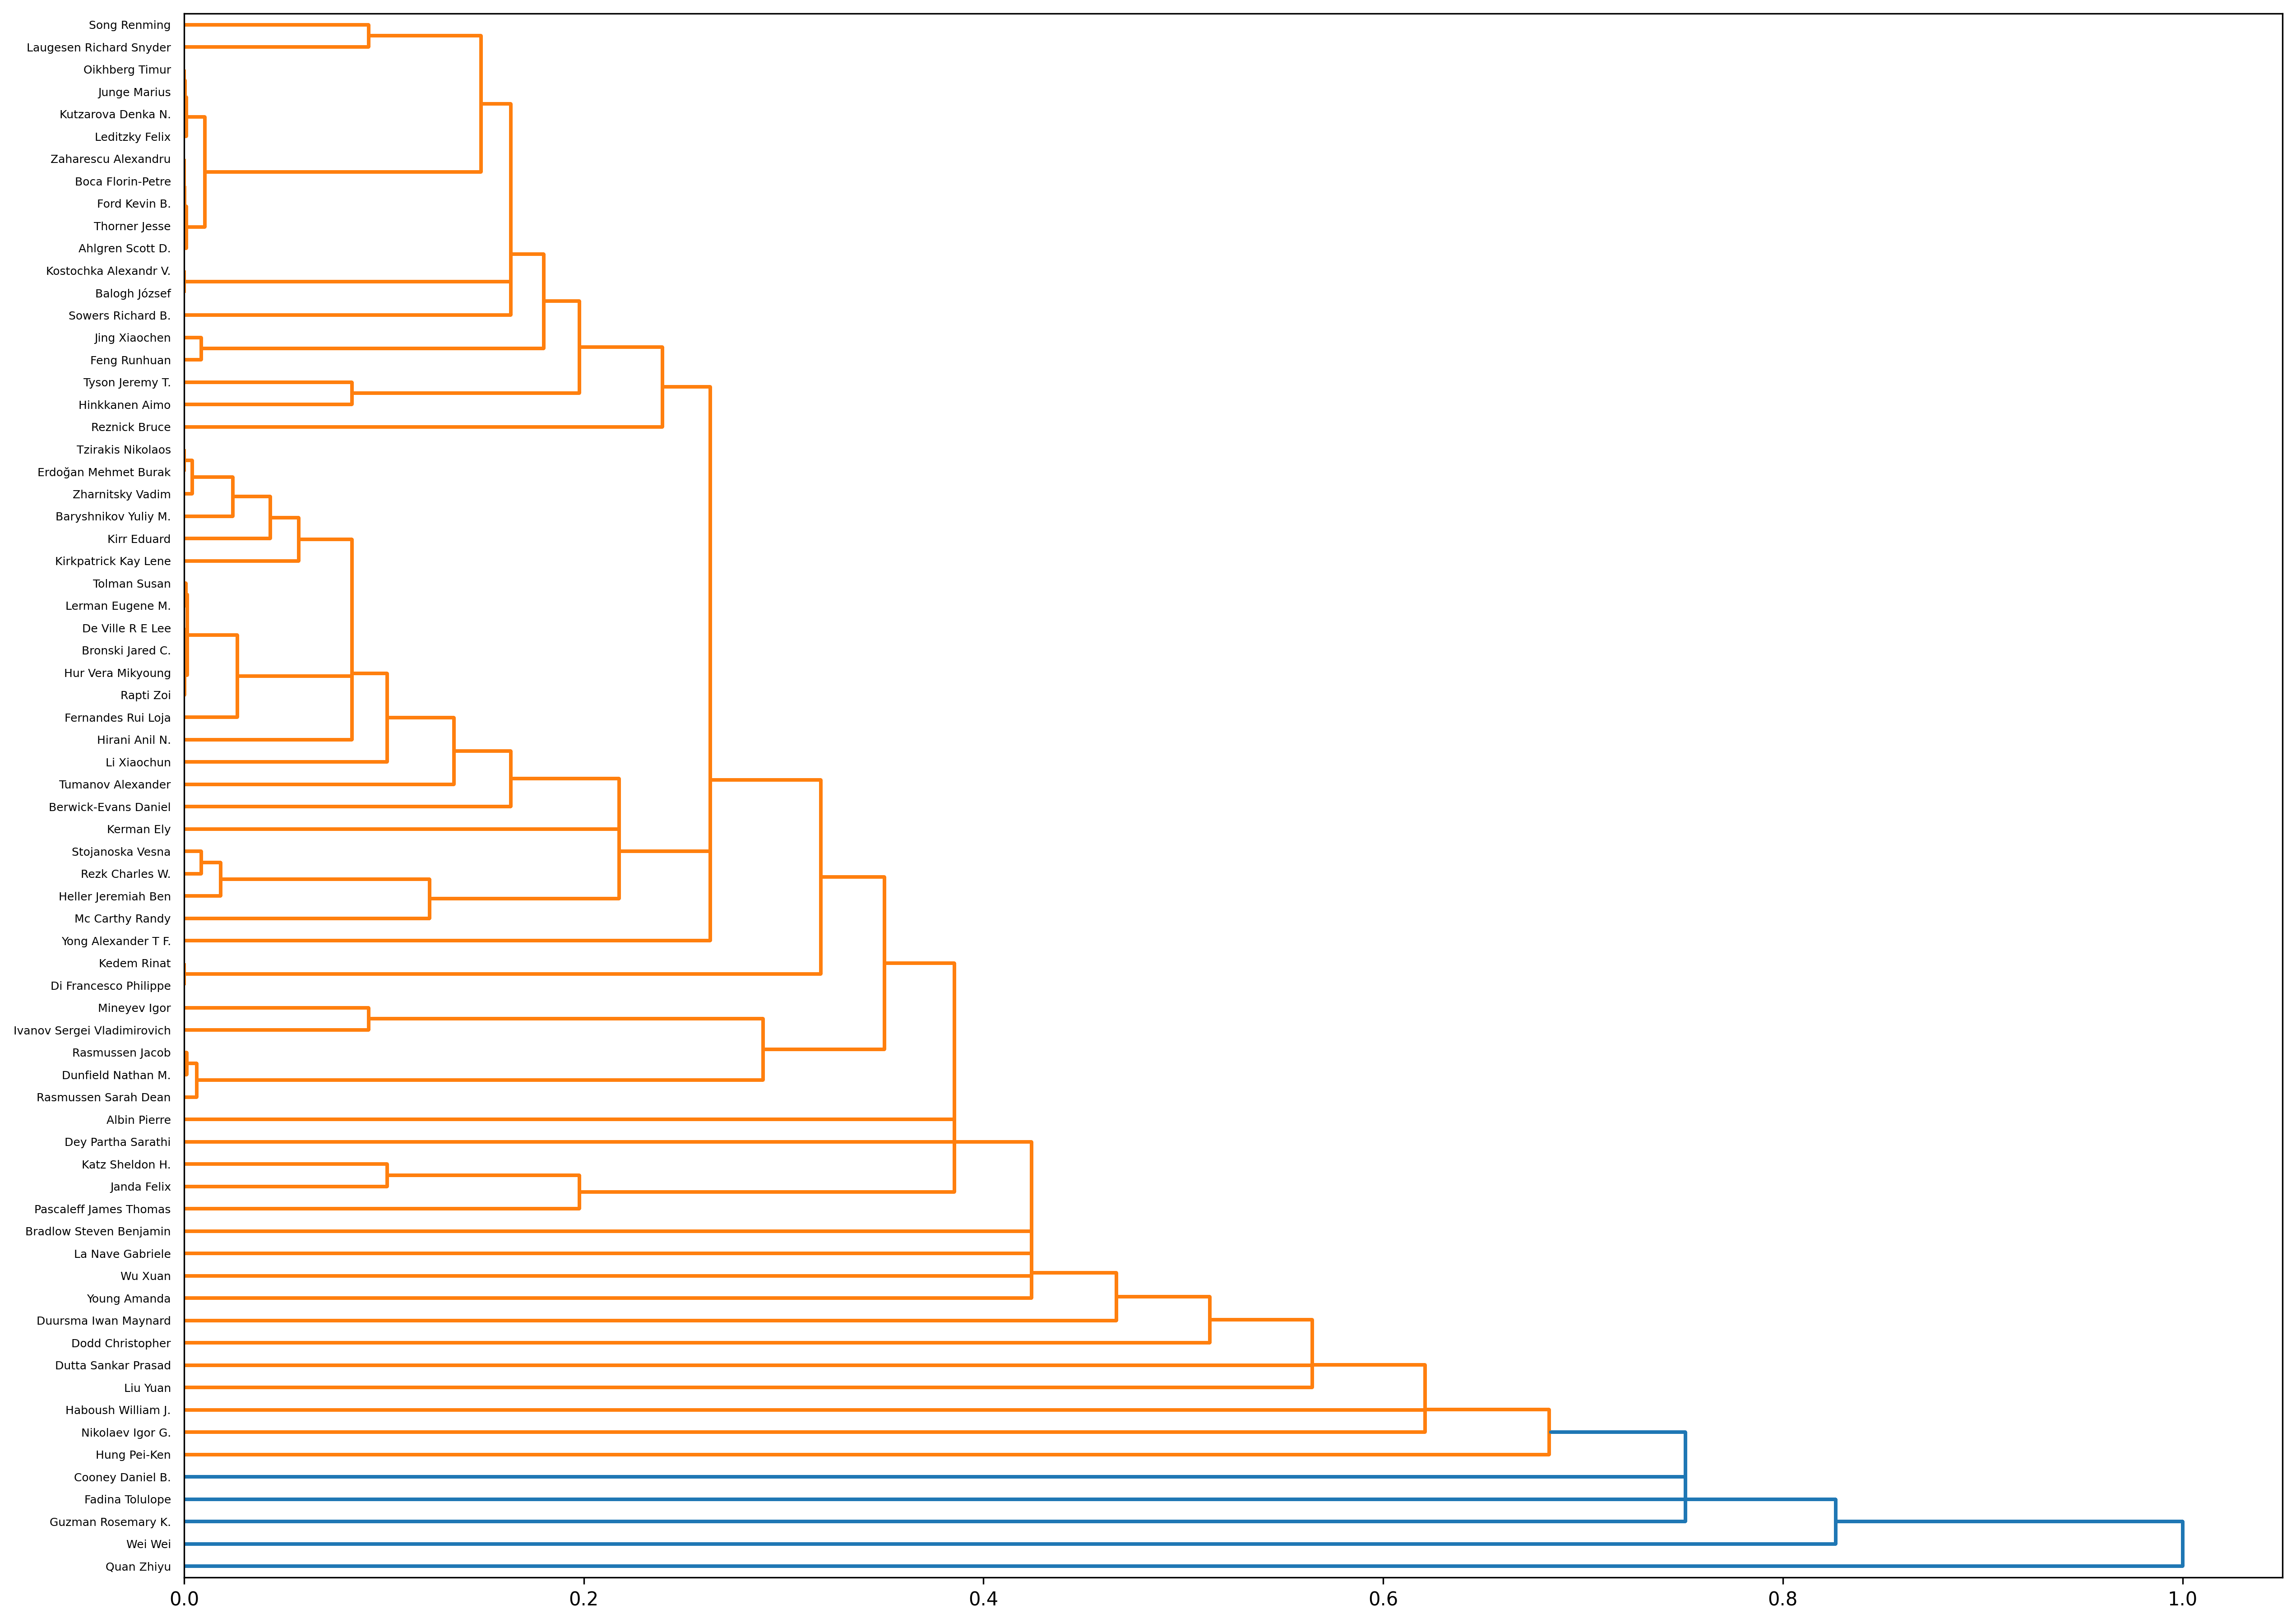

In [23]:
sim_com_ref = df[faculties].to_numpy() # Convert the similarity of common references into a numpy array
distance_matrix = d1(sim_com_ref,1.1) # Obtain the distance matrix

#print(distance_matrix)
plot_dendrogram(d1(sim_com_ref,1.1), faculties_no_underscores, linkage="single") #Plot the tree

In [24]:
# Save hierarchical clustering result as Newick format tree
from scipy.cluster.hierarchy import to_tree

linkage_matrix = linkage(distance_matrix, method='single', metric='euclidean')
# Convert hierarchical clustering result to tree structure
tree = to_tree(linkage_matrix)

C:\Users\praje\AppData\Local\Temp\ipykernel_30980\851409798.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='single', metric='euclidean')


We also create heatmaps to visualize the distance matrices.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

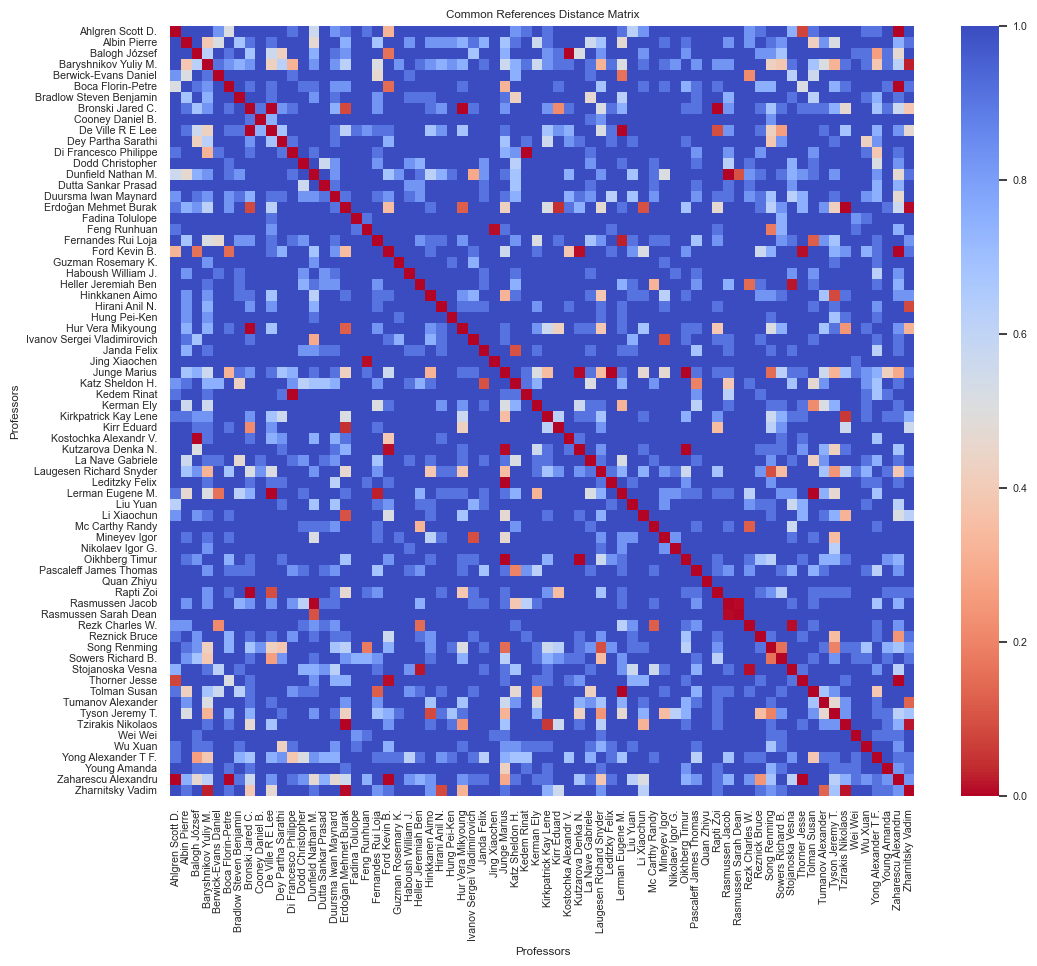

In [27]:
# Set the plot size and color mapping
plt.figure(figsize=(12, 10))  
sns.heatmap(distance_matrix, cmap="coolwarm_r")
#Make the font smaller to fit nicely
sns.set(font_scale=0.7)  

# We set the plot ticks as our list of faculty names
plt.xticks(ticks=np.arange(len(faculties_no_underscores)) + .5, labels=faculties_no_underscores, rotation=90)
plt.yticks(ticks=np.arange(len(faculties_no_underscores)) + .5, labels=faculties_no_underscores, rotation=360)

# General titles for clarity
plt.xlabel('Professors')
plt.ylabel('Professors')

plt.title('Common References Distance Matrix') 

plt.show()

Now we do the same for the common journals data.

In [28]:
df_ = pd.read_csv("similarity_journals.csv") # Let's read a similarity matrix into a pandas dataframe 

faculties2 = list(df_.columns)  # Obtain a list of facluty names
faculties2.pop(0) # Remove unecessary data in the list

faculties_no_underscores2 = faculties2
#print("faculties: ", faculties)
faculties2 = [faculty.replace(" ", "_") for faculty in faculties2] #We replace spaces with "_" for newick format conversion
df_.columns = [''] + faculties2

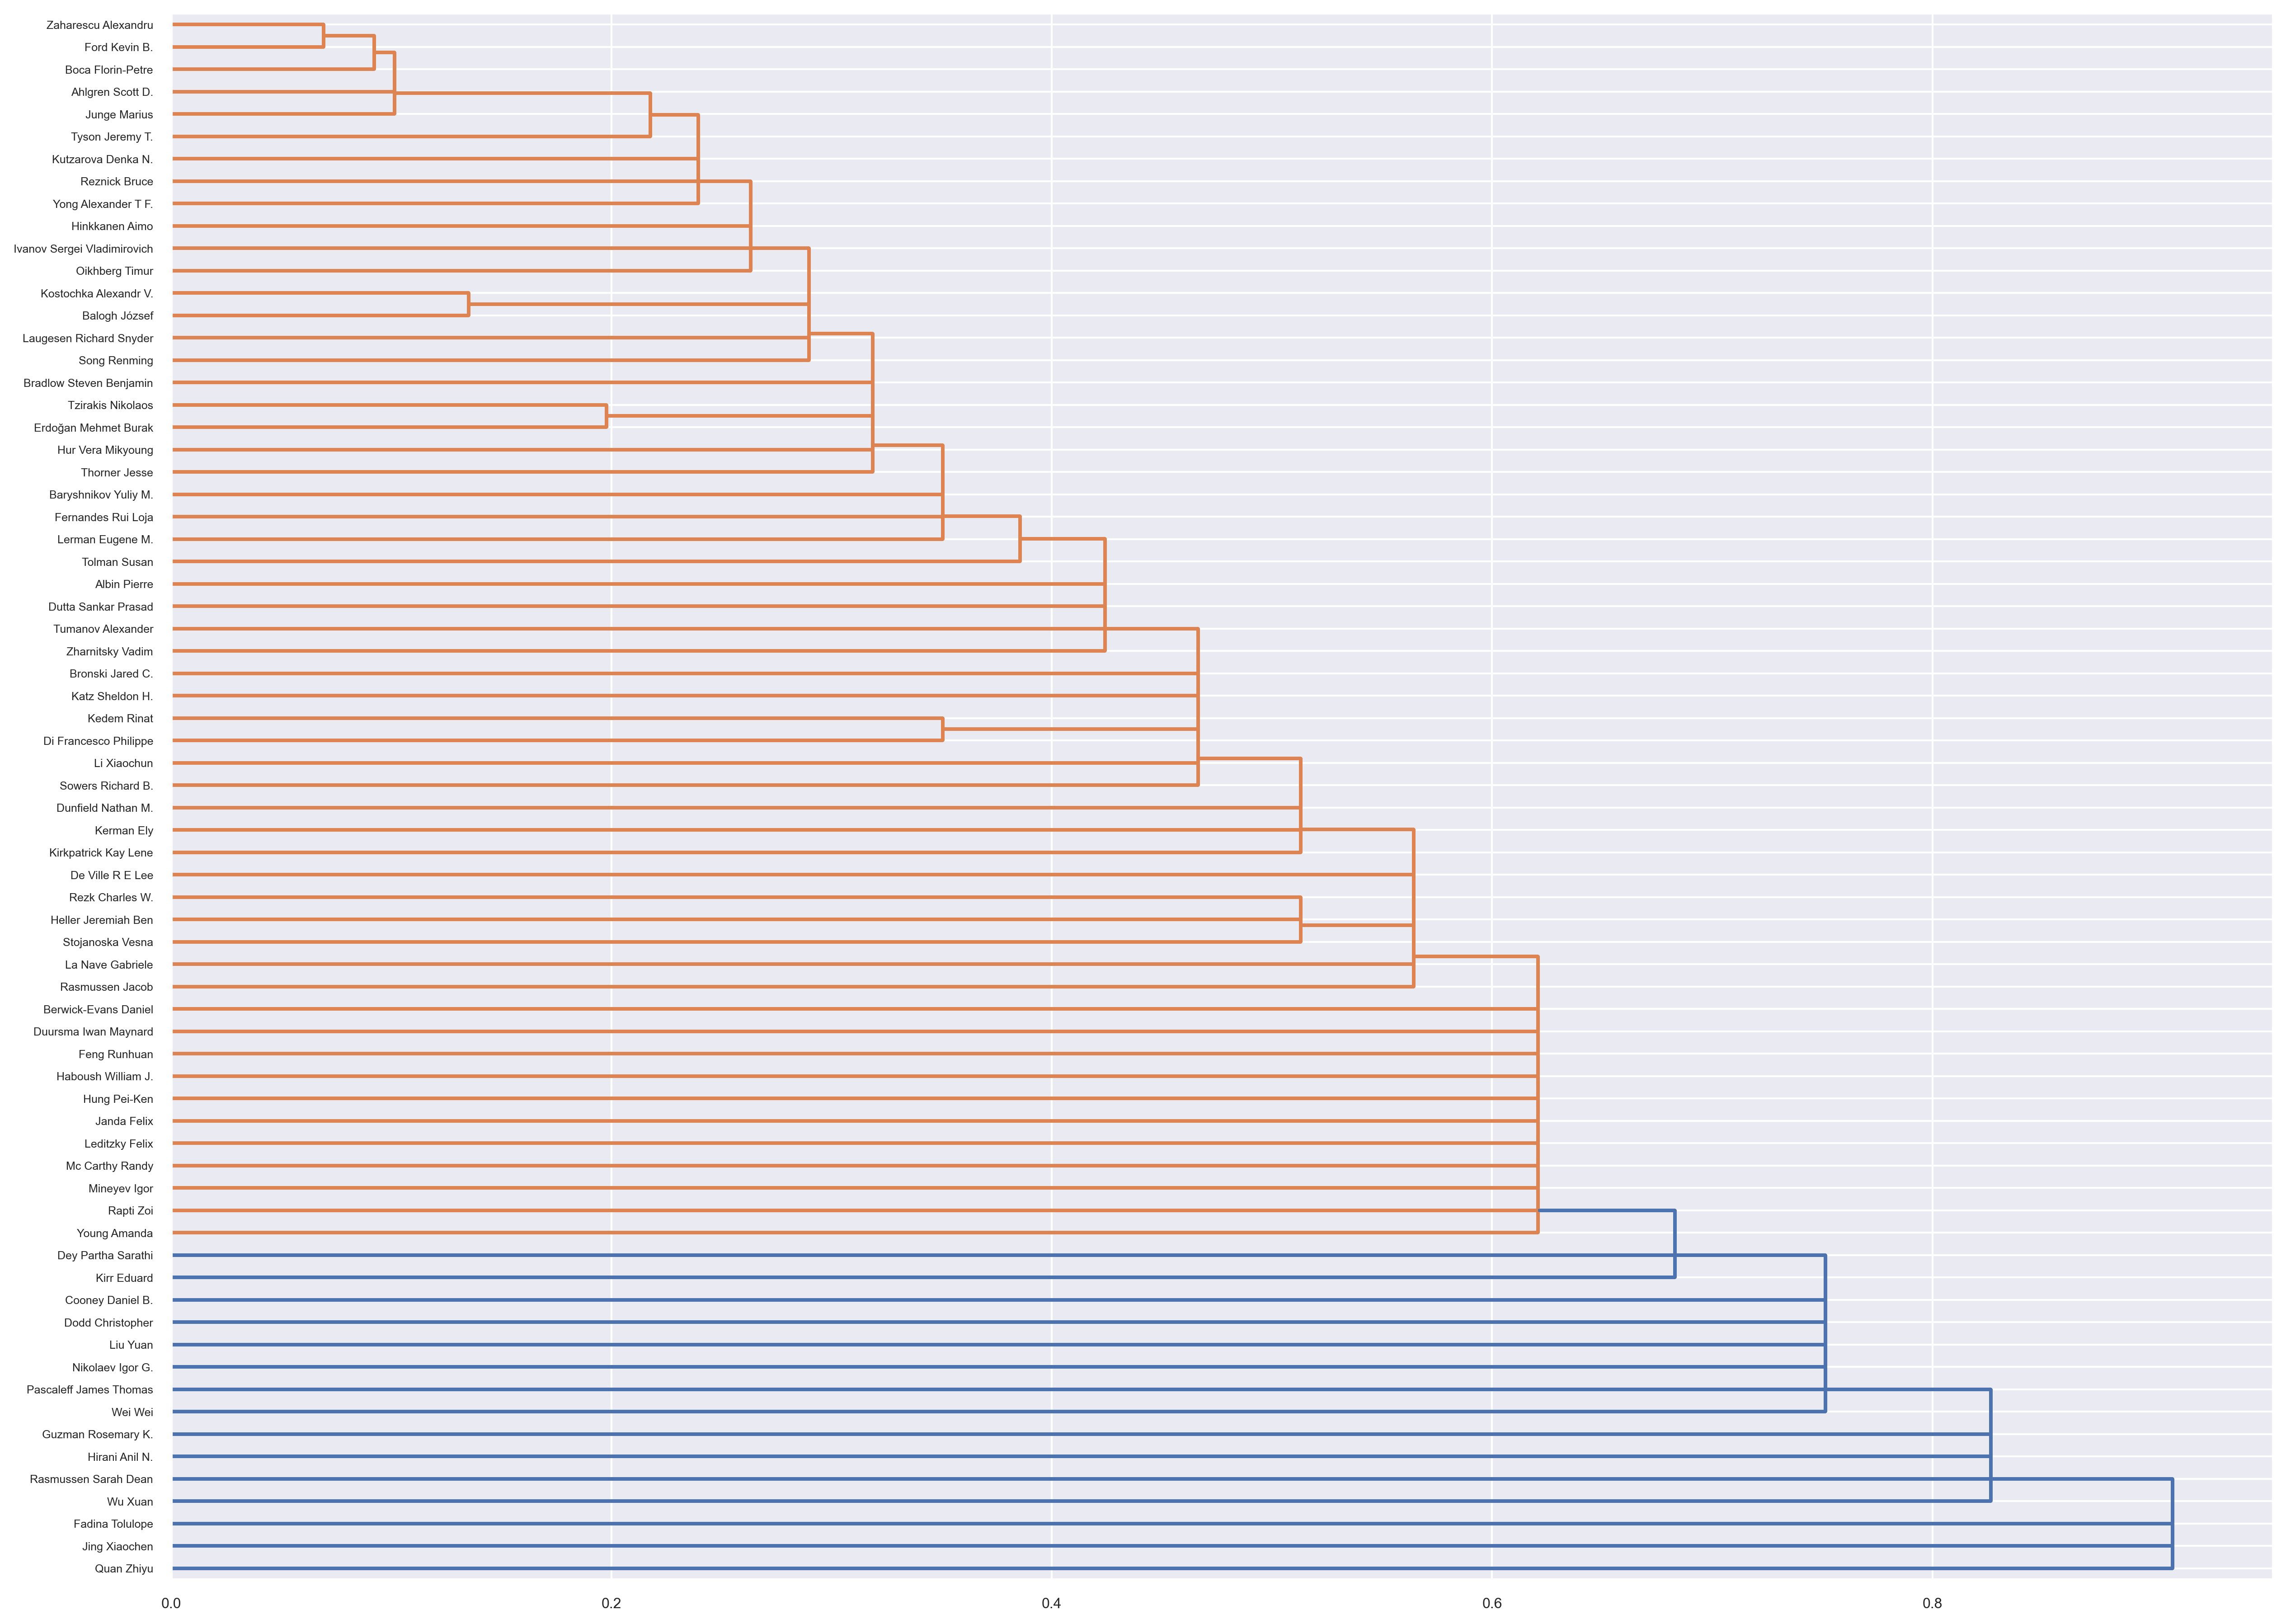

In [29]:
sim_journal_ref = df_[faculties2].to_numpy() # Convert the similarity matrix into a numpy array
distance_matrix_2 = d1(sim_journal_ref,1.1) # Obtain the distance matrix
#print(distance_matrix)
plot_dendrogram(d1(sim_journal_ref,1.1), faculties_no_underscores2, linkage="single") #Plot the tree

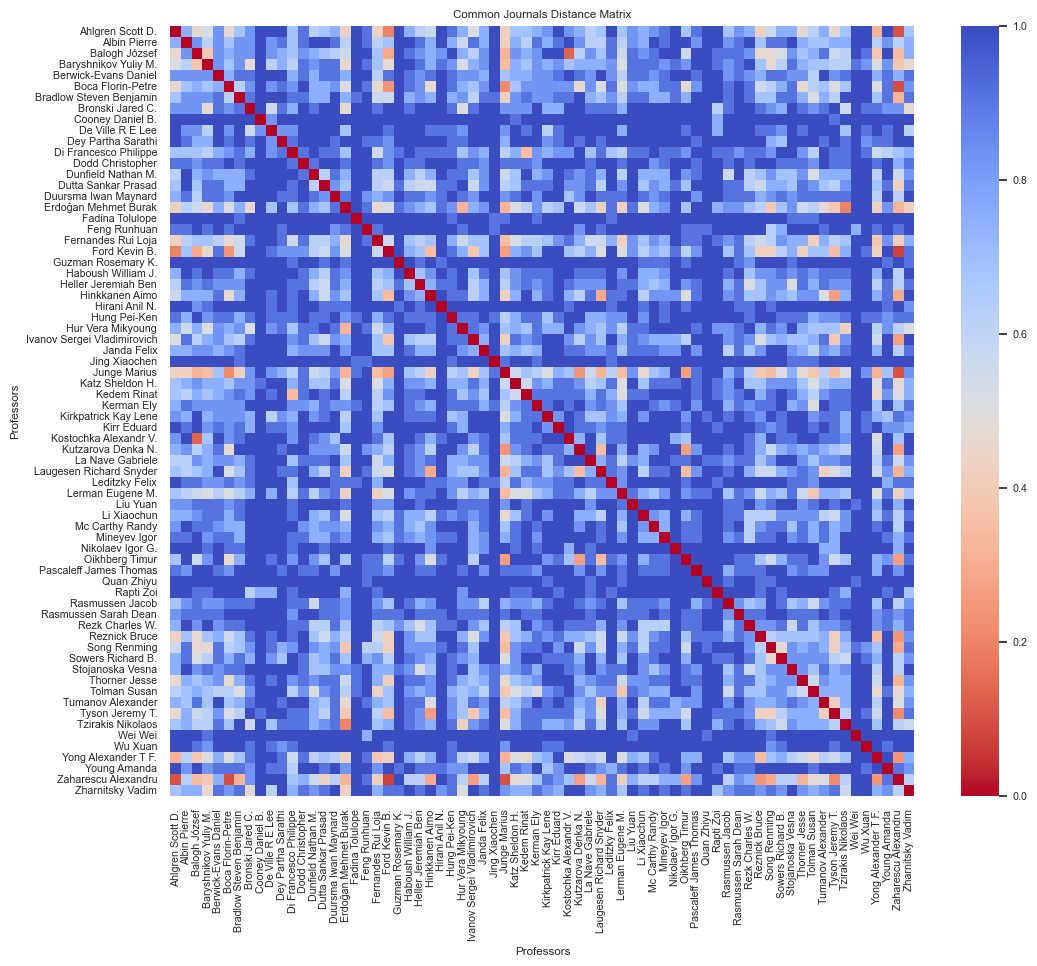

In [30]:
#We set the paramaters for the image and the color map
plt.figure(figsize=(12, 10))  
sns.heatmap(distance_matrix_2, cmap="coolwarm_r")
#Change font size to fit nicely
sns.set(font_scale=0.7)  

#Set the ticks as the list of professors
plt.xticks(ticks=np.arange(len(faculties_no_underscores2)) + .5, labels=faculties_no_underscores2, rotation=90)
plt.yticks(ticks=np.arange(len(faculties_no_underscores2)) + .5, labels=faculties_no_underscores2, rotation=360)

#General titles for clarity
plt.xlabel('Professors')
plt.ylabel('Professors')


plt.title('Common Journals Distance Matrix') 

plt.show()

MSC Data

In [41]:
'''

Function to calculate distance matrix for the MSC similarity matrix using inner product

INPUT: Similarity Matrix

OUTPUT: Distance Matrix where d(A, B) = sqrt( 1 - [<v_A, v_B> / |v_A||v_B|]), we will use the froebius norm


'''

def d2(similarity, r):
    dist = np.zeros(similarity.shape)

    # Iterate through every prof_A, prof_B combination
    for prof_A in range(dist.shape[0]):
        v_A = similarity[prof_A]
       
        for prof_B in range(dist.shape[0]):
            v_B = similarity[prof_B]
            

            denom = (la.norm(v_A) * la.norm(v_B)) 

            
            dist[prof_A][prof_B] = np.sqrt(1 - (np.dot(v_A, v_B) / denom))
    
    # Replace distances with themselves with 0's        
    np.fill_diagonal(dist, 0)
    return dist

In [42]:
df_ = pd.read_csv("similarity_msc.csv") # Let's read a similarity matrix into a pandas dataframe 

faculties2 = list(df_.columns)  # Obtain a list of facluty names
faculties2.pop(0) # Remove unecessary data in the list

faculties_no_underscores2 = faculties2
#print("faculties: ", faculties)
faculties2 = [faculty.replace(" ", "_") for faculty in faculties2] #We replace spaces with "_" for newick format conversion
df_.columns = [''] + faculties2

Tree using the D1 method 

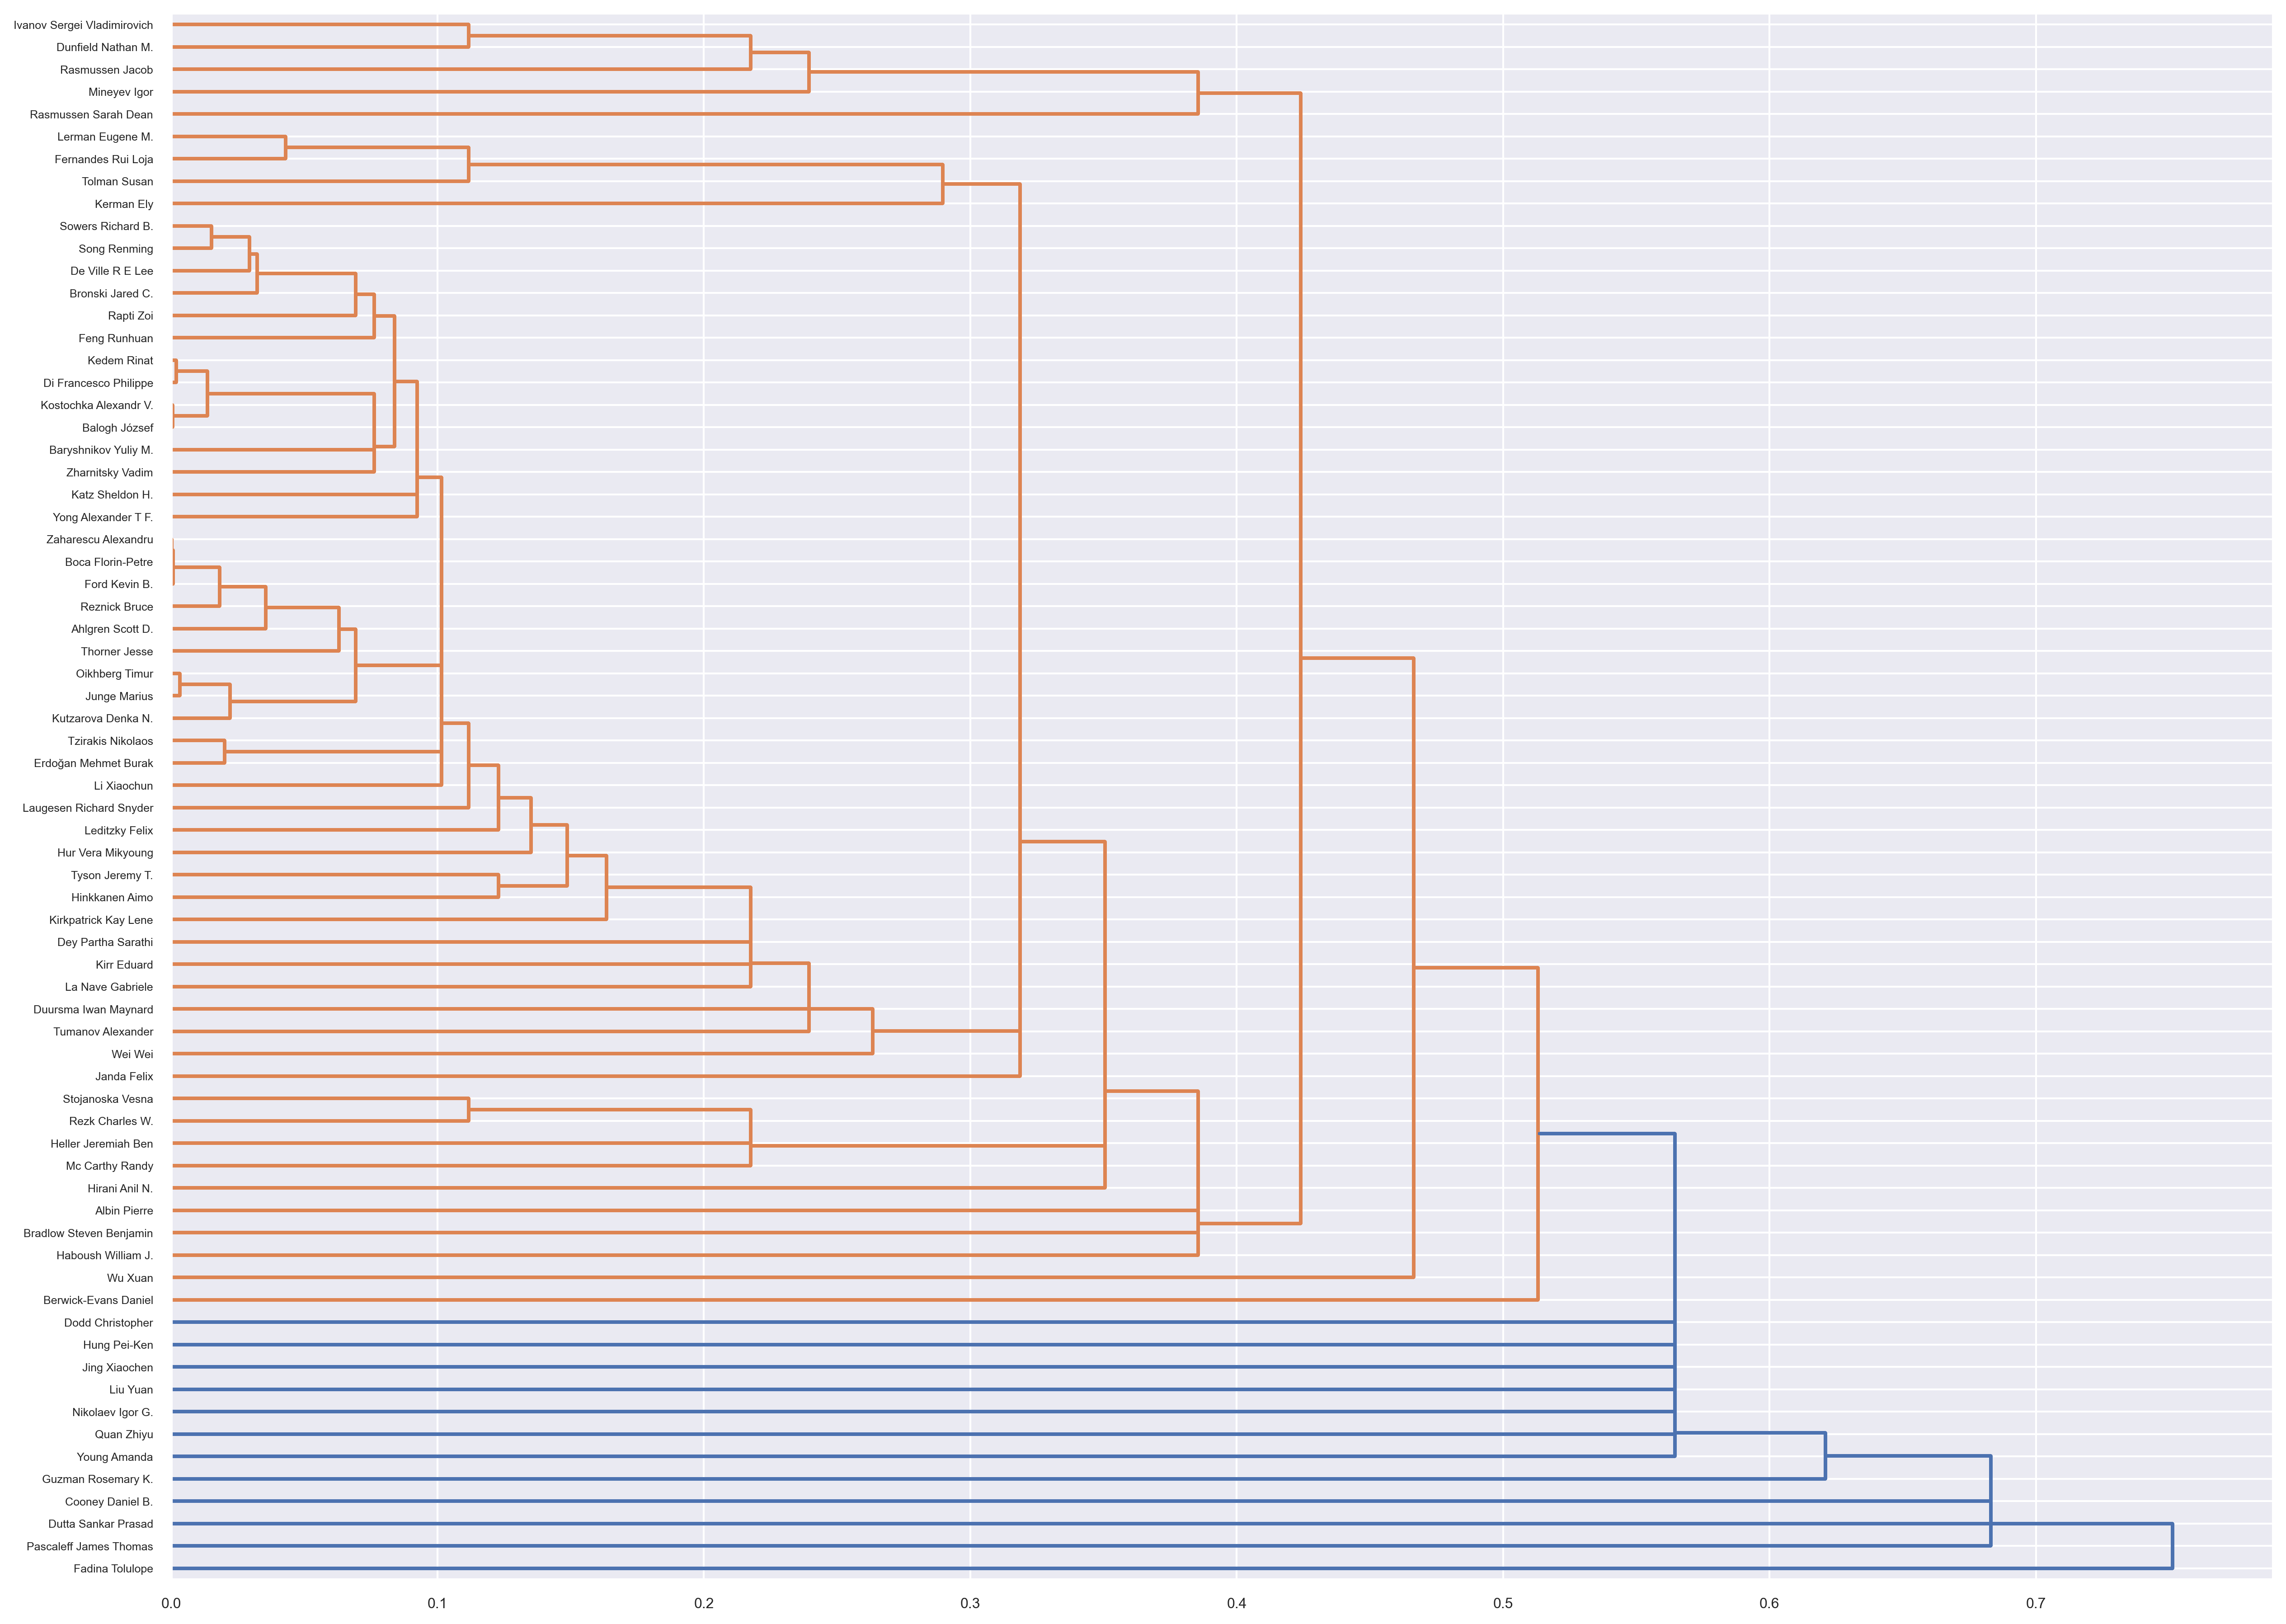

In [43]:
sim_MSC_ref = df_[faculties2].to_numpy() # Convert the similarity matrix into a numpy array
distance_matrix_2 = d1(sim_MSC_ref,1.1) # Obtain the distance matrix
#print(distance_matrix)
plot_dendrogram(distance_matrix_2, faculties_no_underscores2, linkage="single") #Plot the tree

Now we use the other distance matrix

C:\Users\praje\AppData\Local\Temp\ipykernel_30980\311999595.py:26: RuntimeWarning: invalid value encountered in sqrt
  dist[prof_A][prof_B] = np.sqrt(1 - (np.dot(v_A, v_B) / denom))


[[0.         0.98824607 0.90929818 ... 0.88179133 0.69377061 0.94075828]
 [0.98824607 0.         0.98163846 ... 0.96856606 0.98930426 0.9075486 ]
 [0.90929818 0.98163846 0.         ... 0.91471294 0.90884591 0.89727817]
 ...
 [0.88179133 0.96856606 0.91471294 ... 0.         0.86011398 0.7955021 ]
 [0.69377061 0.98930426 0.90884591 ... 0.86011398 0.         0.95121518]
 [0.94075828 0.9075486  0.89727817 ... 0.7955021  0.95121518 0.        ]]


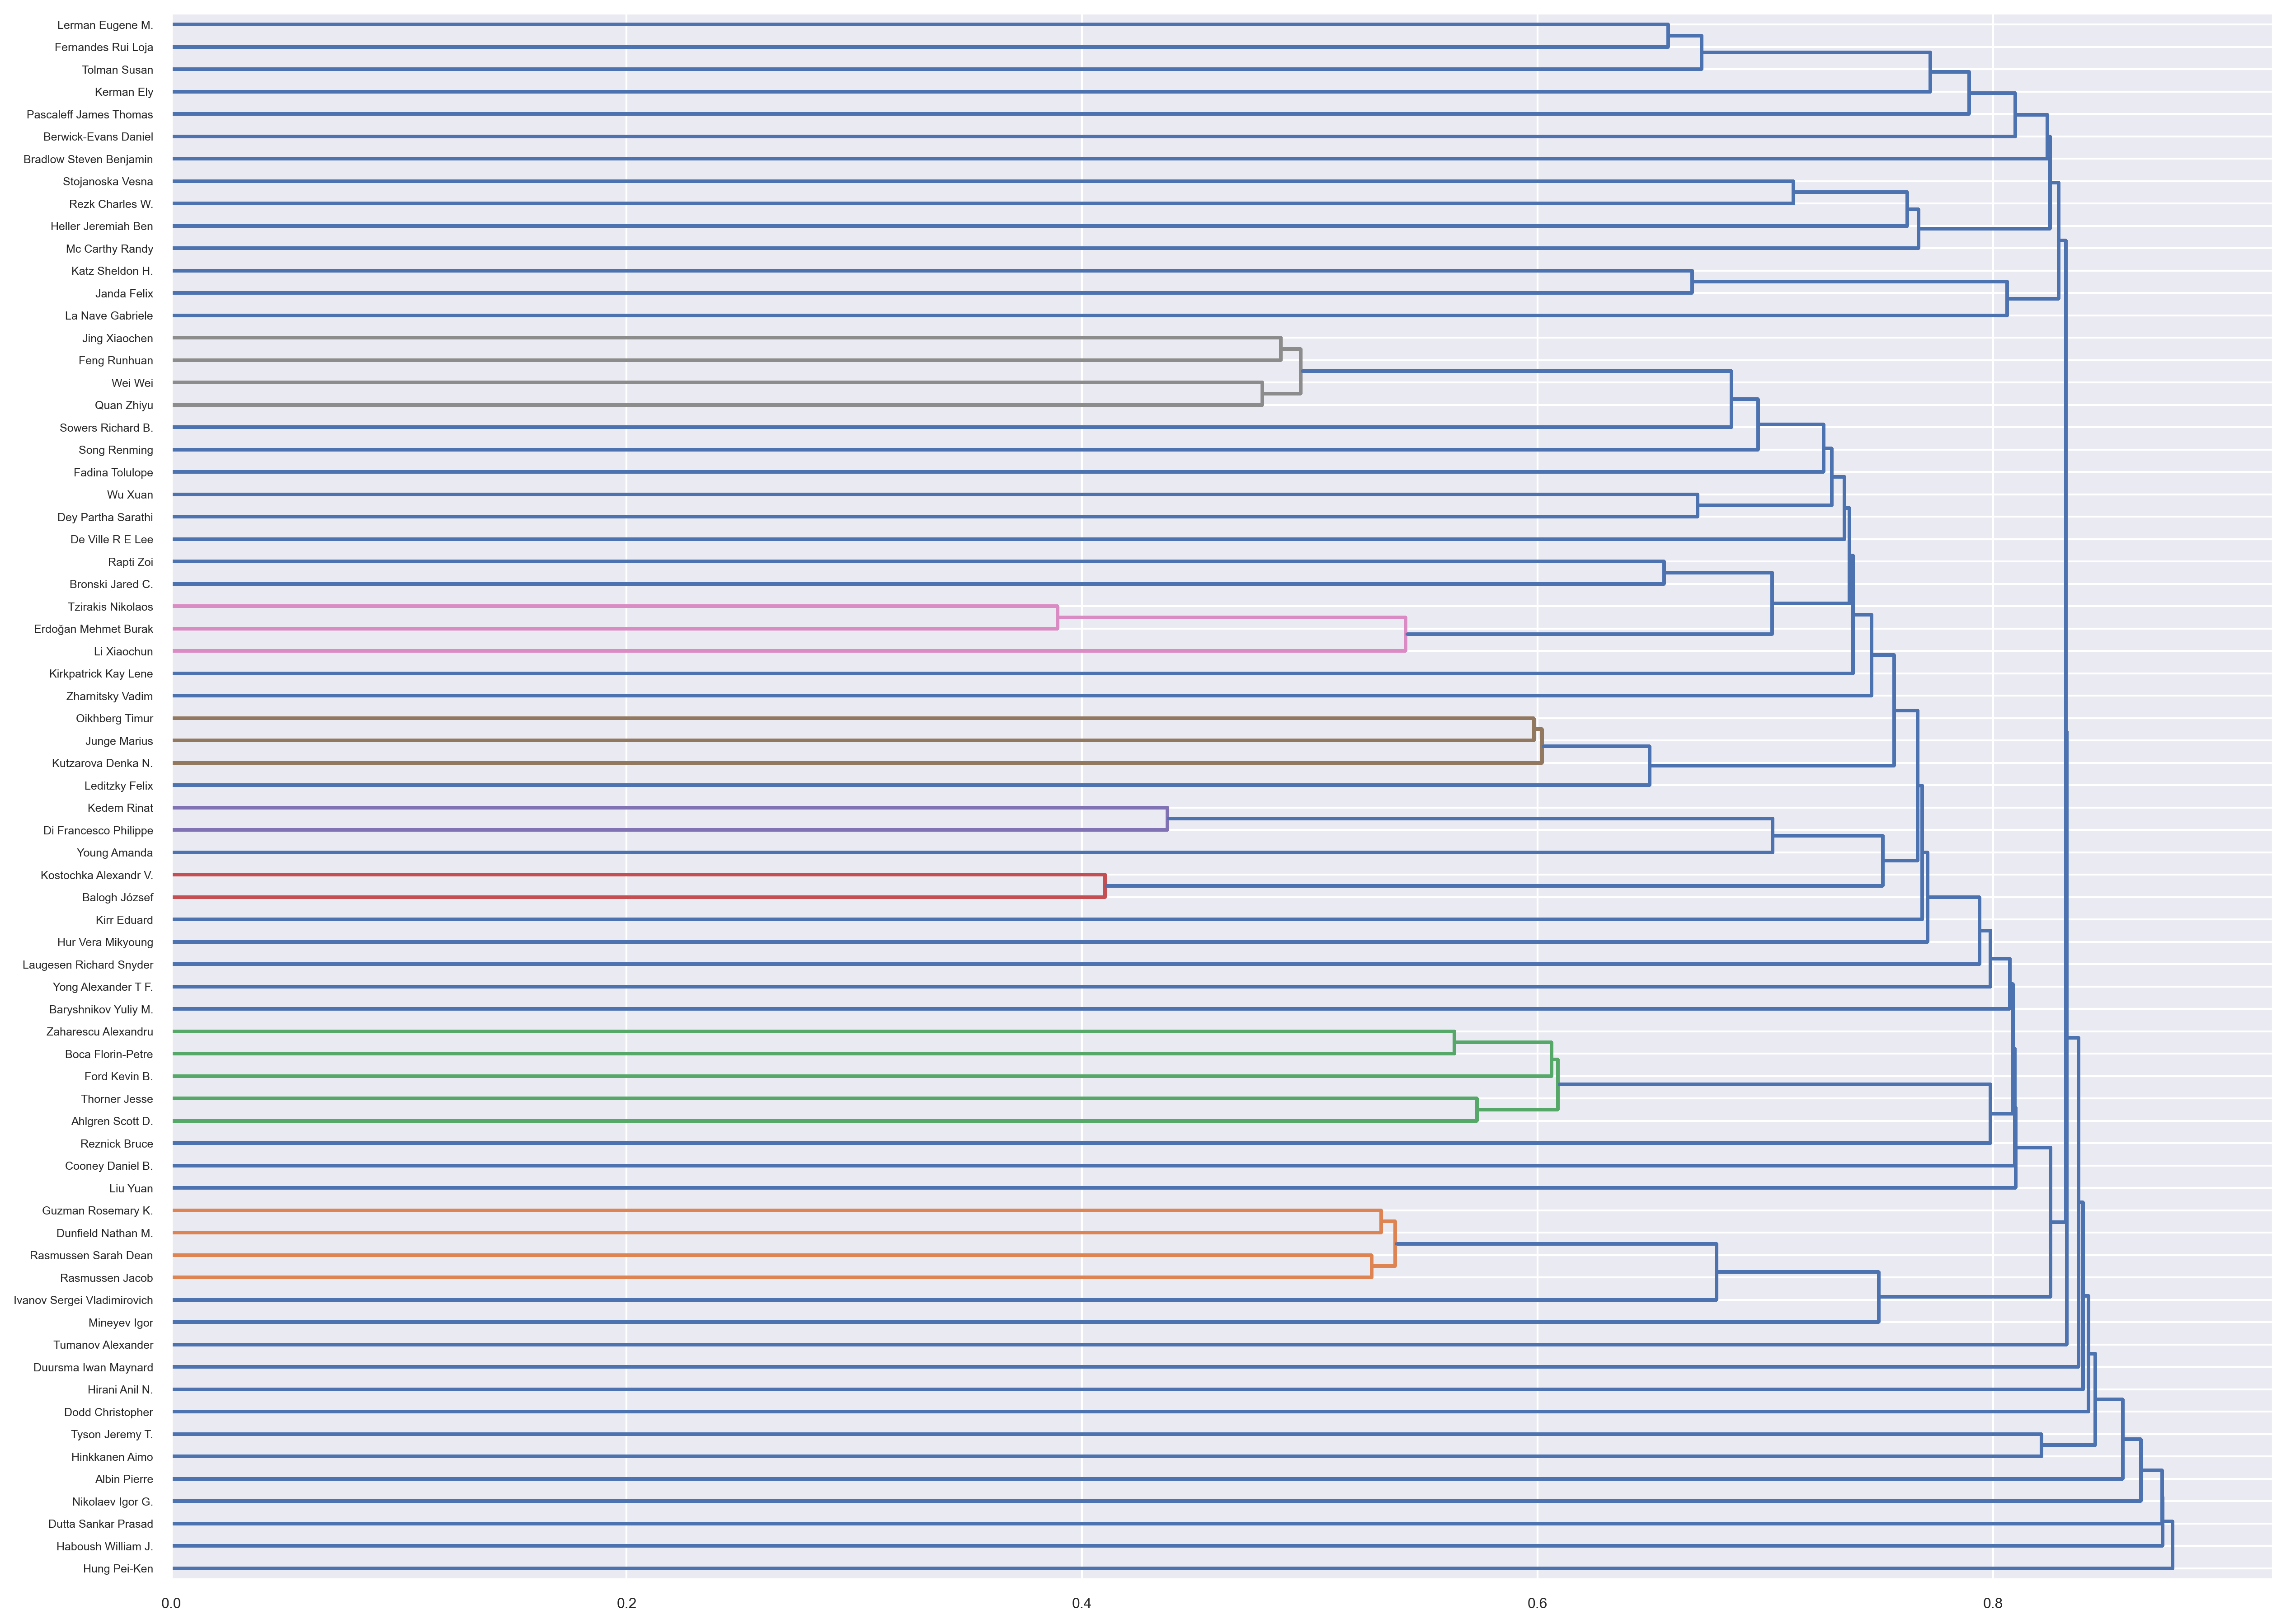

In [45]:
distance_matrix_2 = d2(sim_MSC_ref,1.1) # Obtain the distance matrix
print(distance_matrix_2)
plot_dendrogram(distance_matrix_2, faculties_no_underscores2, linkage="single") #Plot the tree

We have respective heatmaps for D1 and D2

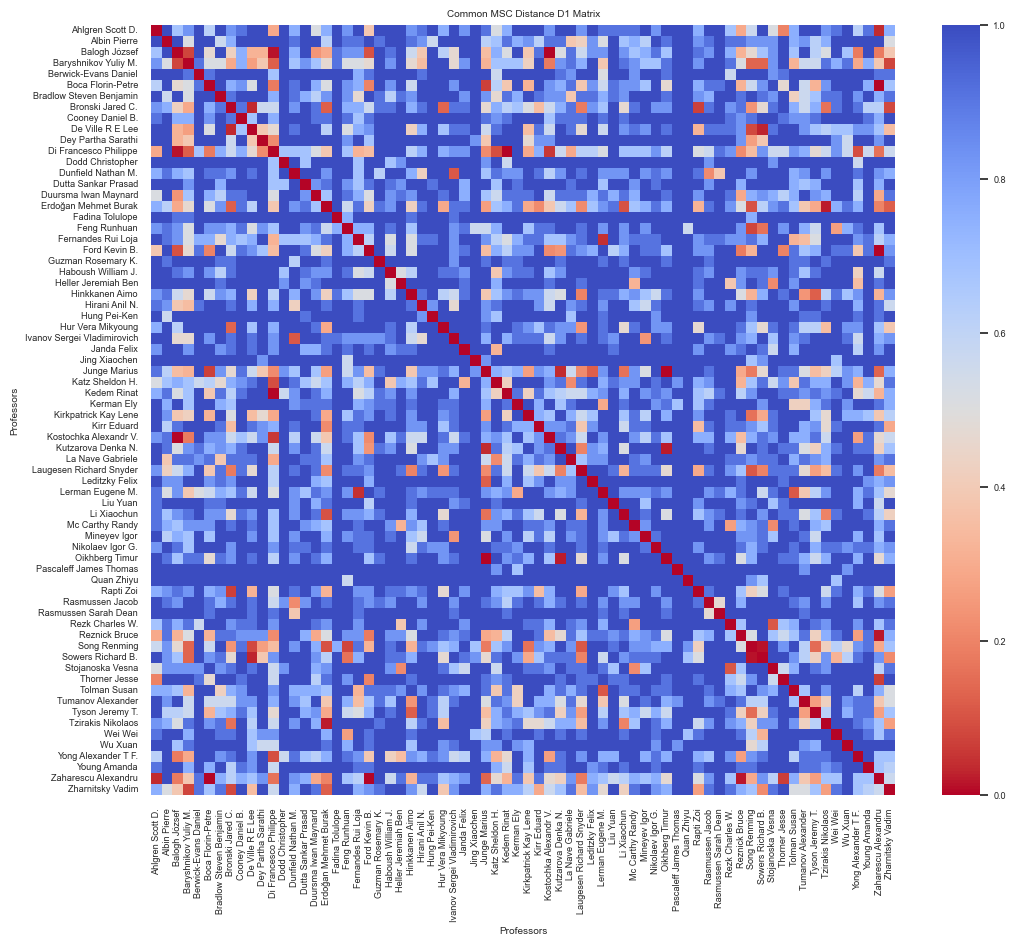

In [48]:
#We set the paramaters for the image and the color map
distance_matrix_2 = d1(sim_MSC_ref,1.1)
plt.figure(figsize=(12, 10))  
sns.heatmap(distance_matrix_2, cmap="coolwarm_r")
#Change font size to fit nicely
sns.set(font_scale=0.6)  

#Set the ticks as the list of professors
plt.xticks(ticks=np.arange(len(faculties_no_underscores2)) + .5, labels=faculties_no_underscores2, rotation=90)
plt.yticks(ticks=np.arange(len(faculties_no_underscores2)) + .5, labels=faculties_no_underscores2, rotation=360)

#General titles for clarity
plt.xlabel('Professors')
plt.ylabel('Professors')


plt.title('Common MSC Distance D1 Matrix') 

plt.show()

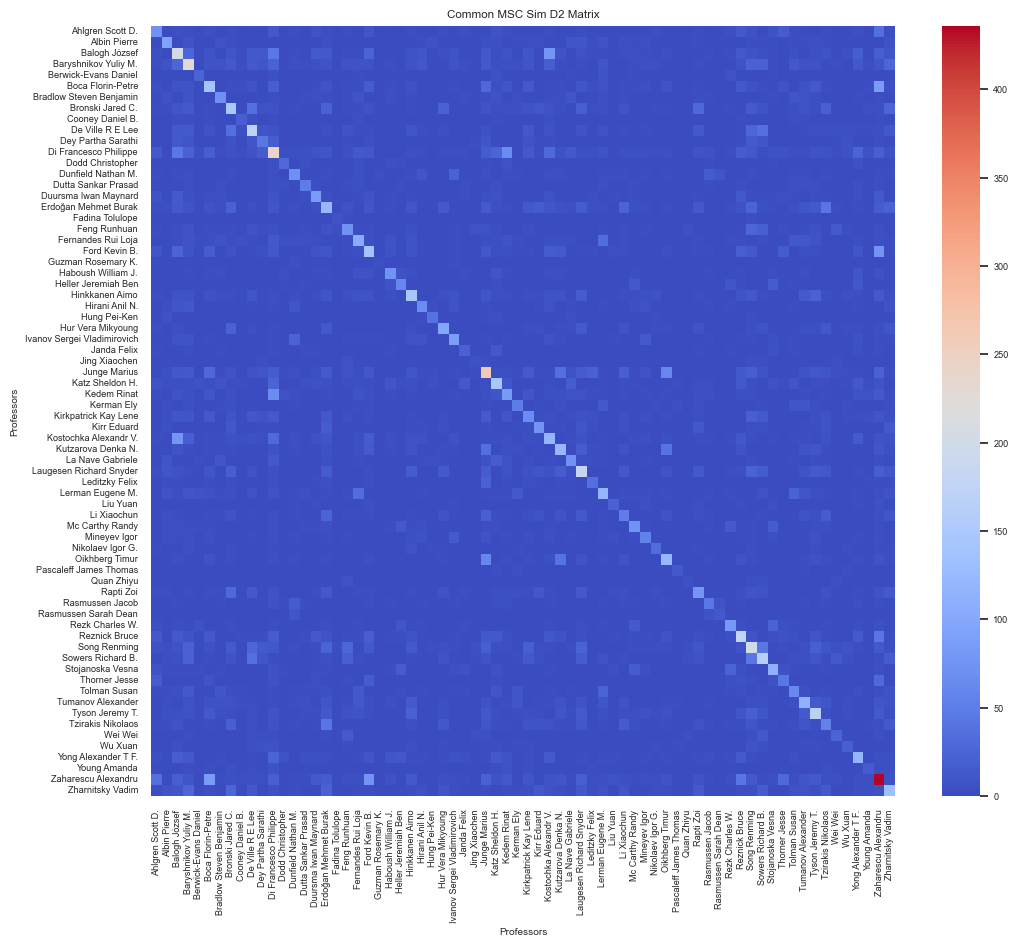

In [49]:
#We set the paramaters for the image and the color map
sim_MSC_ref = df_[faculties2].to_numpy()
distance_matrix_2 = sim_MSC_ref
plt.figure(figsize=(12, 10))  
sns.heatmap(distance_matrix_2, cmap="coolwarm")
#Change font size to fit nicely
sns.set(font_scale=0.7)  

#Set the ticks as the list of professors
plt.xticks(ticks=np.arange(len(faculties_no_underscores2)) + .5, labels=faculties_no_underscores2, rotation=90)
plt.yticks(ticks=np.arange(len(faculties_no_underscores2)) + .5, labels=faculties_no_underscores2, rotation=360)

#General titles for clarity
plt.xlabel('Professors')
plt.ylabel('Professors')


plt.title('Common MSC Sim D2 Matrix') 

plt.show()

From this point forward we will be using our D2 method to calculate distance for all trees, as it generates less extreme results.  Now call back to our process described in step 4 in the initial explanation:

4.  We take the three trees and use the "pathtrees.py" file in the pathtrees repository in order to generate the barycenter through an iterative process: (note numpathtree = # of endpoint trees + pathtrees)

    a. Input: numpathtrees = 3, MSC, REF.  This generates one pathtree between these starting trees\
       Output: Output0(we save the first of these pathtrees)

    b. Input: numpathtrees = 4, Output0, Journal.  This generates two pathtrees between Output0 and Journal.\
       Output: output1 

    c. For an arbitrary N > 0 iterations we have:\
    \
       Input: numpathtrees = 3 + N, outputN, (MSC, REF, Journal) <- dependant on stage of iteration\
       Final Output: outputN -> Will be the barycenter\
       \
    In general, this process can be repeated for as many iterations as needed to keep finding more and more precise barycenters.

Note there is commented code of the pathtrees file we use attached in the box folder.


Finally we generate the trees at every iteration:

In [6]:
''' 

We take an input from our process of iteratively generating pathtrees between our three trees 
(MSC, Journals, Refs), eventually stopping iteration at a suitable barycenter.

This file is formatted with "OutputX:", where X is the stage of the iteration, and beneath the iteration
is the tree generated at that step.

e.g. 

Output0:
((Leaf:Branch, Leaf:Branch) Leaf:Branch, Leaf:Branch) ... )
Output1:
...

The code below generates all trees for each iteration, the final being the current barycenter generated.

The name of each file represents the tree's iteration (its name) and then the two trees it was found between

e.g

output1_MSC_Journal.png is output1 and is found between MSC and Journal

output7_REF_o6.png is output7 and is found between REF and output6


'''
barycenter = ...
input_file = "17_outputs.txt"

with open(input_file, 'r') as file:
    content = file.read()

    outputs = content.split(";")

    curr_output = 0

    
    barycenter_number = len(outputs) - 2

    endpt_trees = ["Ref", "Journal", "MSC"]

    for output in outputs:

        file_addition = "_" + endpt_trees[curr_output % 3] + "_o" + str(curr_output - 1)

        if curr_output == 0:
            file_addition = "_MSC_REF"

        # Clean the file
        str_curr_output = str(curr_output)
        output = output.replace("Output" + str_curr_output + ":", "").strip()
        output += ";"

        # Name the outfile
        out_file = "output" + str_curr_output + file_addition + ".png"

        # Read the tree from the current output
        t = Tree(output)

        # We can now work with the 'tree' object
        ts = TreeStyle()
        ts.show_leaf_name = True
        ts.mode = "c"
        ts.arc_start = 180 # 0 degrees = 3 o'clock
        ts.arc_span = 180
        ts.scale = 250

        if curr_output == barycenter_number:
            barycenter = t
            ts.scale = 1000
        #ts.show_branch_length = True
        

        t.render(out_file, tree_style=ts, w= 250, units = "mm", dpi= 300)

        curr_output += 1
        

Including our barycenter:

In [7]:
# A pop out rendering of our barycenter

ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"
ts.arc_start = 180 # 0 degrees = 3 o'clock
ts.arc_span = 180
ts.scale = 1000

barycenter.show(tree_style=ts)

![Barycenter-18 iterations](output17_MSC_o16.png)